### Initialize the client

As seen in the "1kg.ipynb" example, we take the following steps to create the client object that will be used to obtain the information we desire and query the server. Plotting tools are also imported here.

In [7]:
import ga4gh.client as client
c = client.HttpClient("http://1kgenomes.ga4gh.org")

import collections
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

### Acquiring annotation set

We query the server for the dataset, which is the 1k-genomes dataset. The dataset has a unique ID that can be used to acquire each variant set within the dataset. 

To access the different kinds of annotations, we access the annotation set using the unique variant set ID.

In [8]:
dataset = c.searchDatasets().next()

for variantSet in c.searchVariantSets(dataset.id):
    if variantSet.name == "functional-annotation":
        annotation = variantSet

annotationSet = c.searchVariantAnnotationSets(variantSetId=annotation.id).next()

In [9]:
def doThings(startPos, endPos, chromosome, searchTerm, window):
    
    windowCount = ((int(endPos)-int(startPos))/int(window))
    print("windowCount = ",windowCount)
    
    abc=c.searchVariantAnnotations(variantAnnotationSetId=annotationSet.id, start=int(startPos), end=int(startPos)+int(window), referenceName=chromosome, effects=[{"id": searchTerm}])
    idList = []
    startEndList = []
    
    for annotation in abc:
        idList.append(annotation.variant_id)
    
    i=0
    for ids in idList:
        important = c.getVariant(ids)
   
        i+=1
        
        startEndList.append(important.start)
        startEndList.append(important.end)
        
    countingStats(seVals=startEndList, windowValue=windowCount)
    

In [10]:
def countingStats(seVals, windowValue):
    values = np.empty([int(len(seVals))/2,2], dtype=np.int32)
    
    
    j=0
    k=1
    for i in range(0,int(len(seVals))/2):
        values[i][0] = seVals[j]
        values[i][1] = seVals[k]
        j+=2
        k+=2
    
    print(values)
    print(len(values))    
   
    plotHistogram(values, np.arange(1,len(values)+1))


In [11]:
def plotHistogram(xAxisTicks,yAxisValues):
    
    fig, ax = plt.subplots()
    
    xRange = np.arange(len(xAxisTicks))

    ax.set_xticklabels(xAxisTicks, rotation=45)
    ax.set_xticks(xRange)
    plt.bar(xRange,yAxisValues,color=['green'],edgecolor="none")

    plt.show()

windowCount =  1
[[13010 13011]
 [13109 13110]
 [13115 13116]
 [13117 13118]
 [13155 13156]]
5


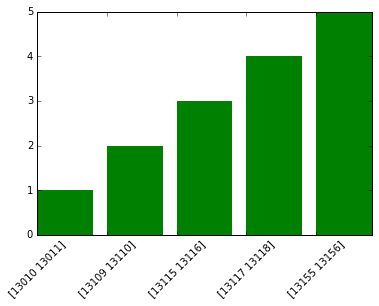

In [13]:
searchOntologyDict = {'transcript_ablation' : 'SO:0001893', 'splice_acceptor_variant' : 'SO:0001574', 'splice_donor_variant' : 'SO:0001575', 'stop_gained' : 'SO:0001587', 'frameshift_variant' : 'SO:0001589', 'stop_lost' : 'SO:0001578', 'start_lost' : 'SO:0002012', 'transcript_amplification' : 'SO:0001889', 'inframe_insertion' : 'SO:0001821', 'inframe_deletion' : 'SO:0001822', 'missense_variant' : 'SO:0001583', 'protein_altering_variant' : 'SO:0001818', 'splice_region_variant' : 'SO:0001630', 'incomplete_terminal_codon_variant' : 'SO:0001626', 'stop_retained_variant' : 'SO:0001567', 'synonymous_variant' : 'SO:0001819', 'coding_sequence_variant' : 'SO:0001580', 'mature_miRNA_variant' : 'SO:0001620', '5_prime_UTR_variant' : 'SO:0001623', '3_prime_UTR_variant' : 'SO:0001624', 'non_coding_transcript_exon_variant' : 'SO:0001792', 'intron_variant' : 'SO:0001627', 'NMD_transcript_variant' : 'SO:0001621', 'non_coding_transcript_variant' : 'SO:0001619', 'upstream_gene_variant' : 'SO:0001631', 'downstream_gene_variant' : 'SO:0001632', 'TFBS_ablation' : 'SO:0001892', 'TFBS_amplification' : 'SO:0001892', 'TF_binding_site_variant' : 'SO:0001782', 'regulatory_region_ablation' : 'SO:0001894', 'regulatory_region_amplification' : 'SO:0001891', 'feature_elongation' : 'SO:0001907', 'regulatory_region_variant' : 'SO:0001566', 'feature_truncation' : 'SO:0001906', 'intergenic_variant' : 'SO:0001628'}
shortDict = {'intron_variant' : 'SO:0001627', 'feature_truncation' : 'SO:0001906' , 'non_coding_transcript_exon_variant' : 'SO:0001792' , 'non_coding_transcript_variant' : 'SO:0001619', 'transcript_ablation' : 'SO:0001893'}
chromList = ('1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18')

elements = interact(doThings,
           startPos="12000",
           endPos="14200",
           chromosome=chromList,
           searchTerm=shortDict,
           window="2200");